In [2]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

In [ ]:
data = pd.read_csv('02-14-2018.csv', on_bad_lines='skip')

   Dst Port  Protocol  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts   Label
0         0         0      112641719             3             0  Benign
1         0         0      112641466             3             0  Benign
2         0         0      112638623             3             0  Benign
3        22         6        6453966            15            10  Benign
4        22         6        8804066            14            11  Benign
Finished Scaling table
Finished splitting into training and test
Setting datasets into tensors
Y Values ['Benign' 'Benign' 'Benign' ... 'Benign' 'Benign' 'Benign']
Creating datasets and loaders for training/testing
Training model for 10 epochs
Epoch 1 Loss: 0.2010, Accuracy: 90.50%
Epoch 2 Loss: 0.1850, Accuracy: 90.92%
Epoch 3 Loss: 0.1850, Accuracy: 90.91%
Epoch 4 Loss: 0.1845, Accuracy: 90.92%
Epoch 5 Loss: 0.1842, Accuracy: 90.92%
Epoch 6 Loss: 0.1839, Accuracy: 90.93%
Epoch 7 Loss: 0.1836, Accuracy: 90.93%
Epoch 8 Loss: 0.1832, Accuracy: 90.93%
Epoch 

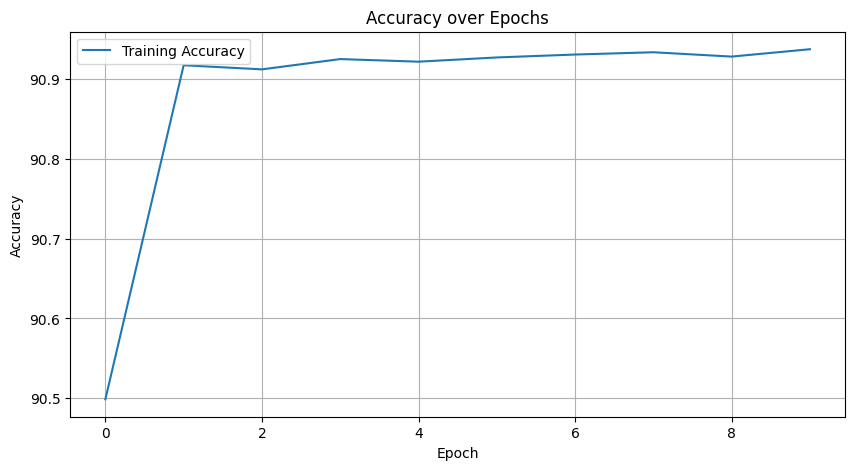

Evaluating Model
Test Accuracy: 91.05%


91.04706690253389

In [ ]:
import pandas as pd
import csv
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os

data = data[["Dst Port", 'Protocol', "Flow Duration", "Tot Fwd Pkts", "Tot Bwd Pkts", "Label"]]
print(data.head())


scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop(['Label'], axis=1))
print("Finished Scaling table")

X = data_scaled
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Finished splitting into training and test")

########################################################################################
#NEURAL NETWORK CLASSIFICATION
class AnomolyDetectionNetwork(nn.Module):
    def __init__(self):
        #Just set up some random layers, but the first and last layers need to be the same, because those based on the features and the possible outputs
        super(AnomolyDetectionNetwork, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, len(y.unique()))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

print("Setting datasets into tensors")
print("Y Values", y.values)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_tensor = torch.tensor(data_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

print("Creating datasets and loaders for training/testing")
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = AnomolyDetectionNetwork()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(num_epochs=10):
    train_accuracy_list = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_accuracy_list.append(epoch_accuracy)
        print(f'Epoch {epoch+1} Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    return train_accuracy_list

def plot_accuracies(train_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

NUM_EPOCHS = 10
print("Training model for", NUM_EPOCHS, "epochs")
train_accuracies = train_model(num_epochs=NUM_EPOCHS)
plot_accuracies(train_accuracies)

def evaluate_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

print("Evaluating Model")
evaluate_model()